In [26]:
import pandas as pd
import numpy as np

import time

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Nacteni datasetu

In [8]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/spambase/spambase.data"
data = pd.read_csv(url, header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
print("Size X:", X.shape, "Size Y:", y.shape)

Size X: (4601, 57) Size Y: (4601,)


## Normalizace

In [9]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
print("X norm size:", X_norm.shape)

X norm size: (4601, 57)


## Vypocet korelacnich koeficientu a filtrace atributu

In [10]:
# pocet atributu ktere budou odstraneny
num_attributes_to_remove = 8

# vypocita korelacni koeficienty
corr = np.corrcoef(X_norm.T, y)
sorted_correlations = sorted(zip(corr[-1, :-1], range(X.shape[1])), reverse=True)

# vyfiltruje atribu s nejnizsim korelacni koeficientem
X_filtered = np.delete(X_norm, [sorted_correlations[i][1] for i in range(num_attributes_to_remove)], axis=1)
print("X filtered size:", X_filtered.shape)


X filtered size: (4601, 49)


## PCA

In [11]:
# PCA
num_components = 20  # počet komponent, které chceme použít
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_norm)
print("X PCA size:", X_pca.shape)

X PCA size: (4601, 20)


## 10-fold cross-validation

In [38]:
def validate_mode(X_input, y_input):
    # konfigurace neuronove site
    hidden_layer_sizes = [(5,), (10,), (20,), (30,), (50,), (100, )]

    # k-fold cross-validation
    kf = KFold(n_splits=10)

    # tabulka vysledku
    results_table = pd.DataFrame(columns=['Fold', 'Hidden Layer Sizes', 'Accuracy'])

    # otestuje presnost klasifikace vsech definovanych konfigurace neuronove size
    print("Progress:")
    for hls in hidden_layer_sizes:

        start = time.time()
        print("10-fold cross-validation %d ..." % hls, end="")

        for fold, (train_index, test_index) in enumerate(kf.split(X_input)):
            # rozdeli data na trenovaci a testovaci
            X_train, X_test = X_input[train_index], X_input[test_index]
            y_train, y_test = y_input[train_index], y_input[test_index]

            # vytvori a natrenuje model site
            mlp = MLPClassifier(hidden_layer_sizes=hls)
            mlp.fit(X_train, y_train)

            # spocita presnost klasifikace modelu
            y_pred = mlp.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)

            # zapise vysledek do tabulky
            results_table = results_table.append({
                'Fold': fold+1,
                'Hidden Layer Sizes': hls,
                'Accuracy': accuracy
            }, ignore_index=True)

        end = time.time()
        print(" Done [%fs]" % (end - start))

    end = time.time()
    print("Finish...\n")

    return results_table

## S vyuzitim PCA

In [39]:
results_table_pca = validate_mode(X_pca, y)

Progress:
10-fold cross-validation 5 ... Done [7.374542s]
10-fold cross-validation 10 ... Done [7.674939s]
10-fold cross-validation 20 ... Done [8.311835s]
10-fold cross-validation 30 ... Done [9.520359s]
10-fold cross-validation 50 ... Done [18.331141s]
10-fold cross-validation 100 ... Done [23.882872s]
Finish...



## Prumerne vysledky

In [40]:
mean_results_pca = results_table_pca.groupby(['Hidden Layer Sizes']).mean()
mean_results_pca['Accuracy'] = mean_results_pca['Accuracy'].map(lambda x: '{:.3%}'.format(x))
print(mean_results_pca)

                   Accuracy
Hidden Layer Sizes         
(5,)                85.853%
(10,)               87.874%
(20,)               88.113%
(30,)               88.199%
(50,)               88.547%
(100,)              88.591%


## Podrobnejsi vysledky

In [41]:
res = results_table_pca.copy()
res['Accuracy'] = res['Accuracy'].map(lambda x: '{:.3%}'.format(x))
print(res)

   Fold Hidden Layer Sizes Accuracy
0     1               (5,)  77.223%
1     2               (5,)  82.174%
2     3               (5,)  84.348%
3     4               (5,)  75.870%
4     5               (5,)  95.000%
5     6               (5,)  93.043%
6     7               (5,)  85.870%
7     8               (5,)  93.696%
8     9               (5,)  93.478%
9    10               (5,)  77.826%
10    1              (10,)  79.393%
11    2              (10,)  85.217%
12    3              (10,)  87.826%
13    4              (10,)  77.609%
14    5              (10,)  95.217%
15    6              (10,)  94.565%
16    7              (10,)  94.130%
17    8              (10,)  92.391%
18    9              (10,)  93.913%
19   10              (10,)  78.478%
20    1              (20,)  80.043%
21    2              (20,)  86.739%
22    3              (20,)  88.696%
23    4              (20,)  77.826%
24    5              (20,)  95.435%
25    6              (20,)  95.217%
26    7              (20,)  

## Stejny postup validace jen pro filtrovany datase a nefitrovany

In [42]:
results_table_filtered = validate_mode(X_filtered, y)

Progress:
10-fold cross-validation 5 ... Done [8.023876s]
10-fold cross-validation 10 ... Done [8.375580s]
10-fold cross-validation 20 ... Done [9.603225s]
10-fold cross-validation 30 ... Done [17.390982s]
10-fold cross-validation 50 ... Done [21.148876s]
10-fold cross-validation 100 ... Done [27.146595s]
Finish...



In [43]:
mean_results_filtered = results_table_filtered.groupby(['Hidden Layer Sizes']).mean()
mean_results_filtered['Accuracy'] = mean_results_filtered['Accuracy'].map(lambda x: '{:.3%}'.format(x))
print(mean_results_filtered)

                   Accuracy
Hidden Layer Sizes         
(5,)                86.417%
(10,)               86.699%
(20,)               87.851%
(30,)               88.872%
(50,)               88.198%
(100,)              89.199%


In [44]:
results_table = validate_mode(X_norm, y)

Progress:
10-fold cross-validation 5 ... Done [8.555000s]
10-fold cross-validation 10 ... Done [8.966112s]
10-fold cross-validation 20 ... Done [9.853545s]
10-fold cross-validation 30 ... Done [18.529736s]
10-fold cross-validation 50 ... Done [22.741219s]
10-fold cross-validation 100 ... Done [28.071320s]
Finish...



In [45]:
mean_results = results_table.groupby(['Hidden Layer Sizes']).mean()
mean_results['Accuracy'] = mean_results['Accuracy'].map(lambda x: '{:.3%}'.format(x))
print(mean_results)

                   Accuracy
Hidden Layer Sizes         
(5,)                89.264%
(10,)               91.047%
(20,)               90.938%
(30,)               91.611%
(50,)               92.154%
(100,)              92.002%


## Porovnani vysledku

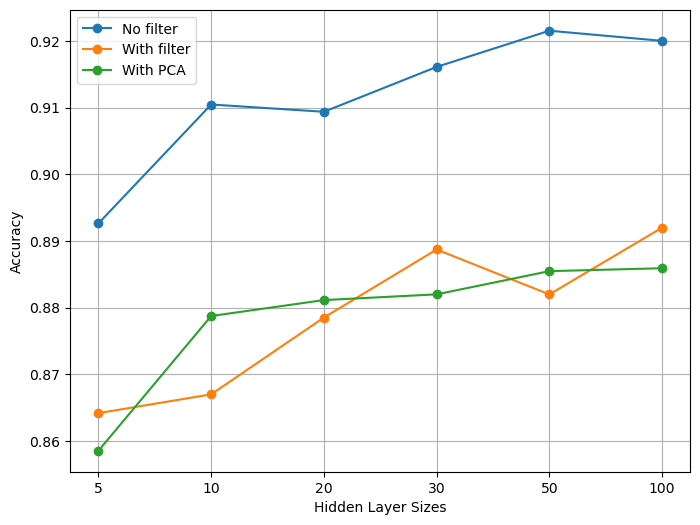

In [46]:
accuracy_values = [float(val.strip('%')) / 100 for val in mean_results['Accuracy'].values]
accuracy_values_filter = [float(val.strip('%')) / 100 for val in mean_results_filtered['Accuracy'].values]
accuracy_values_pca = [float(val.strip('%')) / 100 for val in mean_results_pca['Accuracy'].values]


plt.figure(figsize=(8, 6))

list = []
for l in mean_results.index:
    list.append(str(l[0]))

plt.plot(list, accuracy_values, '-o', label='No filter')
plt.plot(list, accuracy_values_filter, '-o', label='With filter')
plt.plot(list, accuracy_values_pca, '-o', label='With PCA')

plt.xlabel('Hidden Layer Sizes')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()